In [23]:
import numpy as np
import matplotlib.pyplot as plt

# Set seed for reproducibility
np.random.seed(42)

In [24]:
def generate_dataset(n_samples=1000, n_features=2, n_classes=5):
    """
    Creates a 2D synthetic dataset with 5 Gaussian clusters (well separable)
    """
    samples_per_class = n_samples // n_classes
    X = []
    y = []

    centers = [
        [2, 2], [6, 8], [10, 2], [8, 10], [4, 6]
    ]

    for class_idx, center in enumerate(centers):
        # Generate points around each center with some noise
        class_X = np.random.randn(samples_per_class, n_features) * 1.5 + center
        class_y = np.zeros((samples_per_class, n_classes))
        class_y[:, class_idx] = 1  # One-hot encoding

        X.append(class_X)
        y.append(class_y)

    X = np.vstack(X)
    y = np.vstack(y)

    # Shuffle
    idx = np.random.permutation(len(X))
    X = X[idx]
    y = y[idx]

    return X, y

X, y = generate_dataset(n_samples=1500, n_features=2, n_classes=5)

# Train-test split (80-20)
split_idx = int(0.8 * len(X))
X_train, X_test = X[:split_idx], X[split_idx:]
y_train, y_test = y[:split_idx], y[split_idx:]

print(f"Dataset created: {X.shape[0]} samples, {X.shape[1]} features, 5 classes")
print(f"Train: {X_train.shape[0]}, Test: {X_test.shape[0]}")

Dataset created: 1500 samples, 2 features, 5 classes
Train: 1200, Test: 300


In [25]:
# ==================== 2. Neural Network Class ====================
class NeuralNetwork:
    def __init__(self, input_size=2, hidden_sizes=[16, 16, 16], output_size=5, lr=0.01):
        """
        Three hidden layer fully connected network
        Architecture: input -> h1 -> h2 -> h3 -> output(5)
        """
        self.lr = lr

        # Initialize weights and biases
        self.W1 = np.random.randn(input_size, hidden_sizes[0]) * 0.5
        self.b1 = np.zeros((1, hidden_sizes[0]))

        self.W2 = np.random.randn(hidden_sizes[0], hidden_sizes[1]) * 0.5
        self.b2 = np.zeros((1, hidden_sizes[1]))

        self.W3 = np.random.randn(hidden_sizes[1], hidden_sizes[2]) * 0.5
        self.b3 = np.zeros((1, hidden_sizes[2]))

        self.W4 = np.random.randn(hidden_sizes[2], output_size) * 0.5
        self.b4 = np.zeros((1, output_size))

    def sigmoid(self, z, deriv=False):
        z = np.clip(z, -500, 500)  # Prevent overflow
        if deriv:
            return z * (1 - z)
        return 1 / (1 + np.exp(-z))

    def softmax(self, z):
        z = z - np.max(z, axis=1, keepdims=True)  # Numerical stability
        exp_z = np.exp(z)
        return exp_z / np.sum(exp_z, axis=1, keepdims=True)

    def forward(self, X):
        """
        Forward pass - returns predictions and caches intermediate values
        """
        # Layer 1
        self.z1 = X @ self.W1 + self.b1
        self.a1 = self.sigmoid(self.z1)

        # Layer 2
        self.z2 = self.a1 @ self.W2 + self.b2
        self.a2 = self.sigmoid(self.z2)

        # Layer 3
        self.z3 = self.a2 @ self.W3 + self.b3
        self.a3 = self.sigmoid(self.z3)

        # Output layer
        self.z4 = self.a3 @ self.W4 + self.b4
        self.a4 = self.softmax(self.z4)  # Probabilities

        return self.a4

    def backward(self, X, y_true):
        """
        Backpropagation with categorical cross-entropy + softmax
        """
        m = X.shape[0]
        y_pred = self.forward(X)

        # Output layer gradient (softmax + cross-entropy => simple difference)
        dz4 = y_pred - y_true  # Shape: (m, 5)

        dW4 = (self.a3.T @ dz4) / m
        db4 = np.sum(dz4, axis=0, keepdims=True) / m

        # Hidden layer 3
        da3 = dz4 @ self.W4.T
        dz3 = da3 * self.sigmoid(self.a3, deriv=True)
        dW3 = (self.a2.T @ dz3) / m
        db3 = np.sum(dz3, axis=0, keepdims=True) / m

        # Hidden layer 2
        da2 = dz3 @ self.W3.T
        dz2 = da2 * self.sigmoid(self.a2, deriv=True)
        dW2 = (self.a1.T @ dz2) / m
        db2 = np.sum(dz2, axis=0, keepdims=True) / m

        # Hidden layer 1
        da1 = dz2 @ self.W2.T
        dz1 = da1 * self.sigmoid(self.a1, deriv=True)
        dW1 = (X.T @ dz1) / m
        db1 = np.sum(dz1, axis=0, keepdims=True) / m

        # Update weights and biases (Gradient Descent)
        self.W4 -= self.lr * dW4
        self.b4 -= self.lr * db4
        self.W3 -= self.lr * dW3
        self.b3 -= self.lr * db3
        self.W2 -= self.lr * dW2
        self.b2 -= self.lr * db2
        self.W1 -= self.lr * dW1
        self.b1 -= self.lr * db1

    def compute_loss(self, X, y):
        """Categorical cross-entropy loss"""
        y_pred = self.forward(X)
        y_pred = np.clip(y_pred, 1e-15, 1 - 1e-15)
        loss = -np.mean(np.sum(y * np.log(y_pred), axis=1))
        return loss

    def predict(self, X):
        probs = self.forward(X)
        return np.argmax(probs, axis=1)

    def train(self, X_train, y_train, X_val, y_val, epochs=2000, print_every=200):
        losses = []
        val_accuracies = []

        for epoch in range(epochs):
            self.backward(X_train, y_train)
            loss = self.compute_loss(X_train, y_train)
            losses.append(loss)

            if epoch % print_every == 0 or epoch == epochs-1:
                val_acc = np.mean(self.predict(X_val) == np.argmax(y_val, axis=1))
                val_accuracies.append(val_acc)
                print(f"Epoch {epoch:4d} | Loss: {loss:.4f} | Val Acc: {val_acc*100:6.2f}%")

        return losses, val_accuracies

In [26]:
# ==================== 3. Train the Model ====================
print("\n" + "="*60)
print("TRAINING 3-HIDDEN-LAYER NEURAL NETWORK (5 classes)")
print("="*60)

nn = NeuralNetwork(input_size=2, hidden_sizes=[20, 20, 20], output_size=5, lr=0.05)

losses, val_accs = nn.train(
    X_train, y_train,
    X_test, y_test,
    epochs=3000,
    print_every=300
)


TRAINING 3-HIDDEN-LAYER NEURAL NETWORK (5 classes)
Epoch    0 | Loss: 1.8389 | Val Acc:  18.00%
Epoch  300 | Loss: 1.4476 | Val Acc:  57.67%
Epoch  600 | Loss: 1.1227 | Val Acc:  61.33%
Epoch  900 | Loss: 0.8966 | Val Acc:  66.33%
Epoch 1200 | Loss: 0.7681 | Val Acc:  75.67%
Epoch 1500 | Loss: 0.6769 | Val Acc:  77.33%
Epoch 1800 | Loss: 0.6075 | Val Acc:  78.33%
Epoch 2100 | Loss: 0.5570 | Val Acc:  79.67%
Epoch 2400 | Loss: 0.5207 | Val Acc:  80.33%
Epoch 2700 | Loss: 0.4941 | Val Acc:  81.00%
Epoch 2999 | Loss: 0.4741 | Val Acc:  81.00%


In [29]:
# ==================== 4. Evaluation Metrics (Pure NumPy) ====================
y_pred_test = nn.predict(X_test)
y_true_test = np.argmax(y_test, axis=1)

# Accuracy

def confusion_matrix(y_true, y_pred, n_classes=5):
    cm = np.zeros((n_classes, n_classes), dtype=int)
    for i in range(len(y_true)):
        cm[y_true[i], y_pred[i]] += 1
    return cm

cm = confusion_matrix(y_true_test, y_pred_test)

# Per-class and overall metrics
def calculate_metrics(cm):
    n_classes = cm.shape[0]
    precision = np.zeros(n_classes)
    recall = np.zeros(n_classes)
    f1 = np.zeros(n_classes)

    for i in range(n_classes):
        tp = cm[i, i]
        fp = np.sum(cm[:, i]) - tp
        fn = np.sum(cm[i, :]) - tp
        tn = np.sum(cm) - tp - fp - fn

        precision[i] = tp / (tp + fp) if (tp + fp) > 0 else 0
        recall[i] = tp / (tp + fn) if (tp + fn) > 0 else 0
        f1[i] = 2 * precision[i] * recall[i] / (precision[i] + recall[i]) if (precision[i] + recall[i]) > 0 else 0

    accuracy = np.trace(cm) / np.sum(cm)
    macro_precision = np.mean(precision)
    macro_recall = np.mean(recall)
    macro_f1 = np.mean(f1)

    return accuracy, precision, recall, f1, macro_precision, macro_recall, macro_f1

accuracy, prec, rec, f1s, m_prec, m_rec, m_f1 = calculate_metrics(cm)

print("\n" + "="*60)
print("FINAL RESULTS")
print("="*60)
print(f"Test Accuracy     : {accuracy*100:.2f}%")
print(f"Macro Precision   : {m_prec:.4f}")
print(f"Macro Recall     : {m_rec:.4f}")
print(f"Macro F1-Score   : {m_f1:.4f}")
print("\nPer-class F1-scores:", np.round(f1s, 2))
print("\nConfusion Matrix:")
print(cm)


FINAL RESULTS
Test Accuracy     : 81.00%
Macro Precision   : 0.7961
Macro Recall     : 0.7977
Macro F1-Score   : 0.7954

Per-class F1-scores: [0.96 0.52 0.98 0.76 0.76]

Confusion Matrix:
[[56  0  0  0  3]
 [ 0 27  0 18  9]
 [ 1  1 71  0  0]
 [ 0  8  1 45  0]
 [ 1 14  0  1 44]]


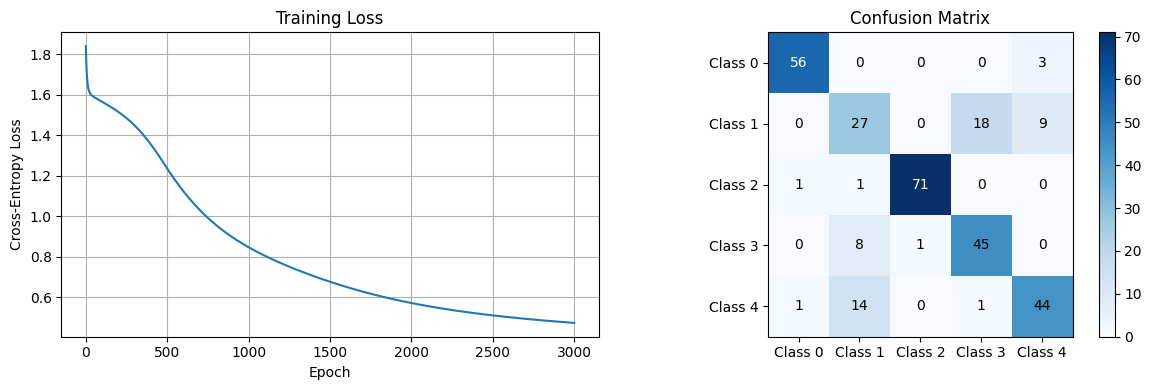

In [30]:
# ==================== 5. Visualization ====================
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(losses)
plt.title("Training Loss")
plt.xlabel("Epoch")
plt.ylabel("Cross-Entropy Loss")
plt.grid(True)

plt.subplot(1, 2, 2)
plt.imshow(cm, cmap="Blues", interpolation='nearest')
plt.title("Confusion Matrix")
plt.colorbar()
tick_marks = np.arange(5)
plt.xticks(tick_marks, [f"Class {i}" for i in range(5)])
plt.yticks(tick_marks, [f"Class {i}" for i in range(5)])
for i in range(5):
    for j in range(5):
        plt.text(j, i, str(cm[i, j]), ha='center', va='center', color='black' if cm[i,j] < 50 else 'white')
plt.tight_layout()
plt.show()

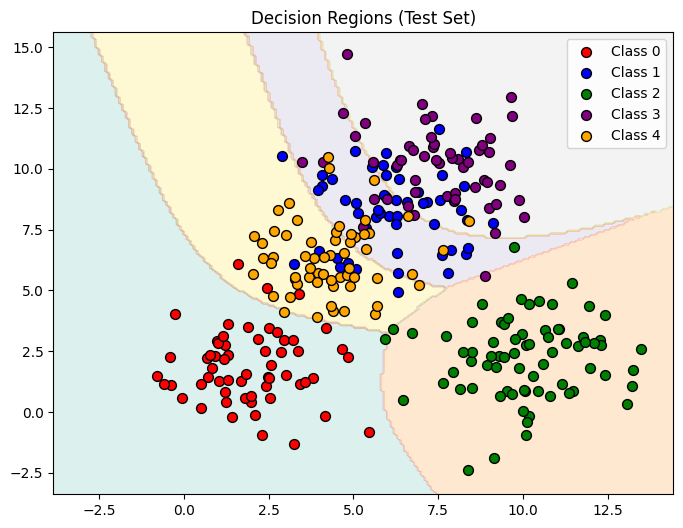

In [31]:
# Scatter plot of data with decision regions (optional bonus)
plt.figure(figsize=(8, 6))
x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.1),
                     np.arange(y_min, y_max, 0.1))
grid = np.c_[xx.ravel(), yy.ravel()]
Z = nn.predict(grid)
Z = Z.reshape(xx.shape)

plt.contourf(xx, yy, Z, alpha=0.3, cmap='Set3')
colors = ['red', 'blue', 'green', 'purple', 'orange']
for i in range(5):
    plt.scatter(X_test[y_true_test==i, 0], X_test[y_true_test==i, 1],
                c=colors[i], label=f'Class {i}', edgecolors='k', s=50)
plt.title("Decision Regions (Test Set)")
plt.legend()
plt.show()